<a href="https://colab.research.google.com/github/sooonsyk/ESAA-22-2/blob/main/W15_session_mon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [12]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

## preparing train data

In [13]:
filenames = os.listdir("/content/drive/MyDrive/train_700")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [14]:
df.head()

,filename,category
0,cat.256.jpg,0
1,cat.530.jpg,0
2,dog.242.jpg,1
3,dog.256.jpg,1
4,cat.295.jpg,0


In [15]:
df.tail()

,filename,category
1397,dog.234.jpg,1
1398,dog.552.jpg,1
1399,dog.546.jpg,1
1400,dog.220.jpg,1
1401,cat.552.jpg,0


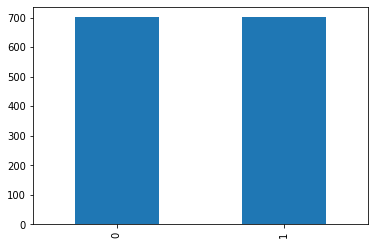

In [16]:
df['category'].value_counts().plot.bar()

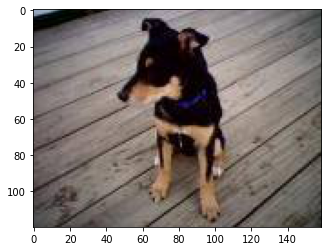

In [17]:
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/train_700/"+sample)
plt.imshow(image)

- Input Layer: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
- Conv Layer: This layer will extract features from image.
- Pooling Layer: This layerreduce the spatial volume of input image after convolution.
- Fully Connected Layer: It connect the network from a layer to another layer
Output Layer: It is the predicted values layer.

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [19]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [20]:
earlystop = EarlyStopping(patience=10)

In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [22]:
callbacks = [earlystop, learning_rate_reduction]

##prepare data

In [23]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [24]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

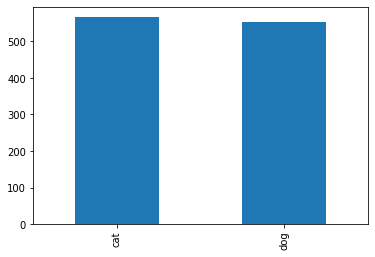

In [25]:
train_df['category'].value_counts().plot.bar()

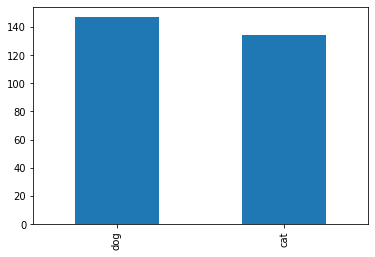

In [26]:
validate_df['category'].value_counts().plot.bar()

In [27]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

##training generator

In [28]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/drive/MyDrive/train_700/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1121 validated image filenames belonging to 2 classes.


In [29]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/train_700/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 281 validated image filenames belonging to 2 classes.


In [30]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/drive/MyDrive/train_700/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


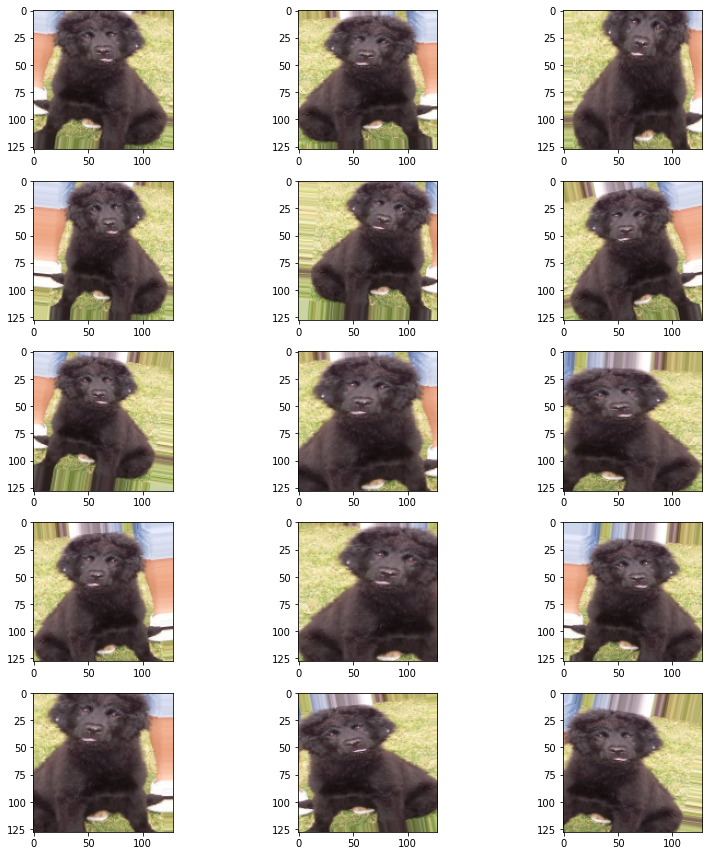

In [31]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

##fit model

In [32]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

<ipython-input-32-63cb34b6e89a>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
74/74 [==============================] - ETA: 0s - loss: 1.3833 - accuracy: 0.5651

74/74 [==============================] - 73s 952ms/step - loss: 1.3833 - accuracy: 0.5651 - val_loss: 0.8656 - val_accuracy: 0.5259 - lr: 0.0010
Epoch 2/50
74/74 [==============================] - ETA: 0s - loss: 1.1349 - accuracy: 0.5452

74/74 [==============================] - 68s 918ms/step - loss: 1.1349 - accuracy: 0.5452 - val_loss: 1.3485 - val_accuracy: 0.4778 - lr: 0.0010
Epoch 3/50
74/74 [==============================] - ETA: 0s - loss: 0.9457 - accuracy: 0.5651

74/74 [==============================] - 68s 917ms/step - loss: 0.9457 - accuracy: 0.5651 - val_loss: 2.5125 - val_accuracy: 0.4852 - lr: 0.0010
Epoch 4/50
74/74 [==============================] - ETA: 0s - loss: 0.8380 - accuracy: 0.6022

74/74 [==============================] - 66s 885ms/step - loss: 0.8380 - accuracy: 0.6022 - val_loss: 0.7053 - val_accuracy: 0.5370 - lr: 0.0010
Epoch 5/50
74/74 [==============================] - ETA: 0s - loss: 0.7576 - accuracy: 0.6022

74/74 [==============================] - 67s 910ms/step - loss: 0.7576 - accuracy: 0.6022 - val_loss: 2.0052 - val_accuracy: 0.4741 - lr: 0.0010
Epoch 6/50
74/74 [==============================] - ETA: 0s - loss: 0.7017 - accuracy: 0.6456

74/74 [==============================] - 65s 884ms/step - loss: 0.7017 - accuracy: 0.6456 - val_loss: 1.4677 - val_accuracy: 0.4852 - lr: 0.0010
Epoch 7/50
74/74 [==============================] - ETA: 0s - loss: 0.6650 - accuracy: 0.6582

74/74 [==============================] - 65s 878ms/step - loss: 0.6650 - accuracy: 0.6582 - val_loss: 0.7523 - val_accuracy: 0.5926 - lr: 0.0010
Epoch 8/50
74/74 [==============================] - ETA: 0s - loss: 0.6588 - accuracy: 0.6528

74/74 [==============================] - 67s 905ms/step - loss: 0.6588 - accuracy: 0.6528 - val_loss: 0.8714 - val_accuracy: 0.5481 - lr: 0.0010
Epoch 9/50
74/74 [==============================] - ETA: 0s - loss: 0.6258 - accuracy: 0.6854

74/74 [==============================] - 65s 877ms/step - loss: 0.6258 - accuracy: 0.6854 - val_loss: 0.6959 - val_accuracy: 0.6519 - lr: 0.0010
Epoch 10/50
74/74 [==============================] - ETA: 0s - loss: 0.6031 - accuracy: 0.6935

74/74 [==============================] - 65s 872ms/step - loss: 0.6031 - accuracy: 0.6935 - val_loss: 0.7482 - val_accuracy: 0.6222 - lr: 0.0010
Epoch 11/50
74/74 [==============================] - ETA: 0s - loss: 0.5899 - accuracy: 0.7089

74/74 [==============================] - 67s 908ms/step - loss: 0.5899 - accuracy: 0.7089 - val_loss: 0.6559 - val_accuracy: 0.6630 - lr: 0.0010
Epoch 12/50
74/74 [==============================] - ETA: 0s - loss: 0.5795 - accuracy: 0.7107

74/74 [==============================] - 65s 872ms/step - loss: 0.5795 - accuracy: 0.7107 - val_loss: 0.5615 - val_accuracy: 0.7259 - lr: 0.0010
Epoch 13/50
74/74 [==============================] - ETA: 0s - loss: 0.5790 - accuracy: 0.7197

74/74 [==============================] - 65s 875ms/step - loss: 0.5790 - accuracy: 0.7197 - val_loss: 0.6168 - val_accuracy: 0.7074 - lr: 0.0010
Epoch 14/50
74/74 [==============================] - ETA: 0s - loss: 0.5602 - accuracy: 0.7251

74/74 [==============================] - 65s 873ms/step - loss: 0.5602 - accuracy: 0.7251 - val_loss: 0.6136 - val_accuracy: 0.6519 - lr: 0.0010
Epoch 15/50
74/74 [==============================] - ETA: 0s - loss: 0.5348 - accuracy: 0.7369

74/74 [==============================] - 67s 910ms/step - loss: 0.5348 - accuracy: 0.7369 - val_loss: 0.5859 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 16/50
74/74 [==============================] - ETA: 0s - loss: 0.5319 - accuracy: 0.7405

74/74 [==============================] - 65s 879ms/step - loss: 0.5319 - accuracy: 0.7405 - val_loss: 0.6365 - val_accuracy: 0.7074 - lr: 0.0010
Epoch 17/50
74/74 [==============================] - ETA: 0s - loss: 0.5274 - accuracy: 0.7387

74/74 [==============================] - 65s 876ms/step - loss: 0.5274 - accuracy: 0.7387 - val_loss: 0.7564 - val_accuracy: 0.6556 - lr: 0.0010
Epoch 18/50
74/74 [==============================] - ETA: 0s - loss: 0.5221 - accuracy: 0.7450

74/74 [==============================] - 67s 909ms/step - loss: 0.5221 - accuracy: 0.7450 - val_loss: 0.7801 - val_accuracy: 0.6296 - lr: 0.0010
Epoch 19/50
74/74 [==============================] - ETA: 0s - loss: 0.4818 - accuracy: 0.7866

74/74 [==============================] - 65s 878ms/step - loss: 0.4818 - accuracy: 0.7866 - val_loss: 0.6611 - val_accuracy: 0.7259 - lr: 0.0010
Epoch 20/50
74/74 [==============================] - ETA: 0s - loss: 0.5273 - accuracy: 0.7568

74/74 [==============================] - 65s 879ms/step - loss: 0.5273 - accuracy: 0.7568 - val_loss: 0.5950 - val_accuracy: 0.6963 - lr: 0.0010
Epoch 21/50
74/74 [==============================] - ETA: 0s - loss: 0.4908 - accuracy: 0.7631

74/74 [==============================] - 66s 889ms/step - loss: 0.4908 - accuracy: 0.7631 - val_loss: 0.6559 - val_accuracy: 0.7148 - lr: 0.0010
Epoch 22/50
74/74 [==============================] - ETA: 0s - loss: 0.4943 - accuracy: 0.7821

74/74 [==============================] - 67s 908ms/step - loss: 0.4943 - accuracy: 0.7821 - val_loss: 0.6815 - val_accuracy: 0.7185 - lr: 0.0010


##save

In [33]:
model.save_weights("model.h5")

## virtualize training

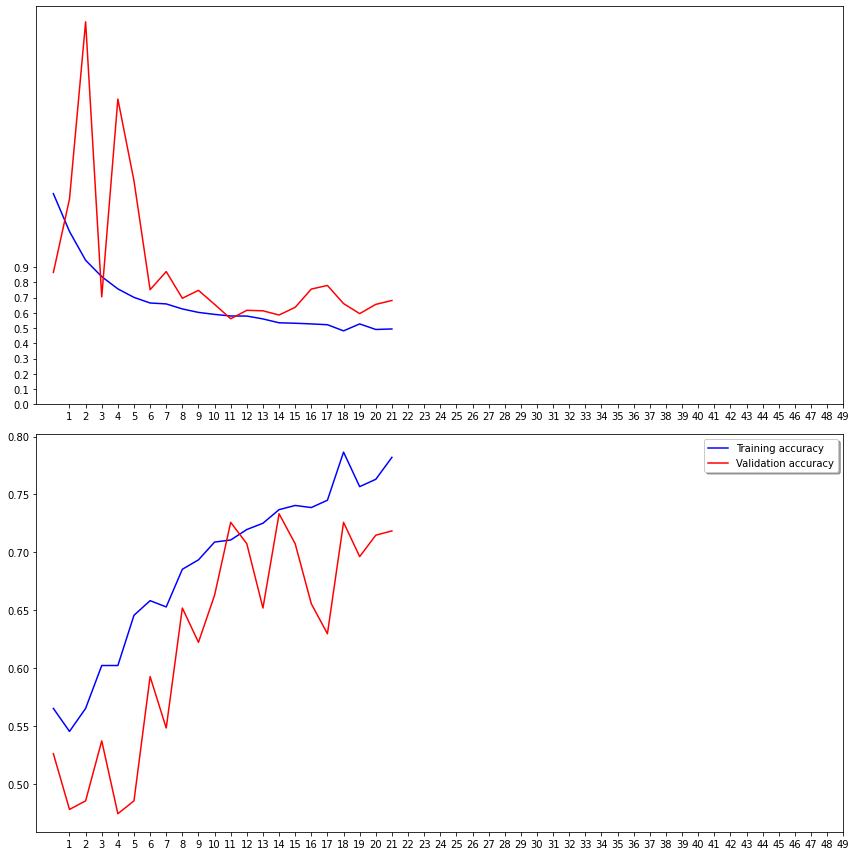

In [34]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

##preparing test data

In [35]:
test_filenames = os.listdir("/content/drive/MyDrive/test_500")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [36]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/drive/MyDrive/test_500/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 500 validated image filenames.


##predict

In [37]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-37-52619fd72ccc>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [38]:
test_df['category'] = np.argmax(predict, axis=-1)

In [39]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [40]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

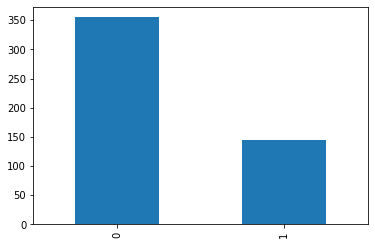

In [41]:
test_df['category'].value_counts().plot.bar()

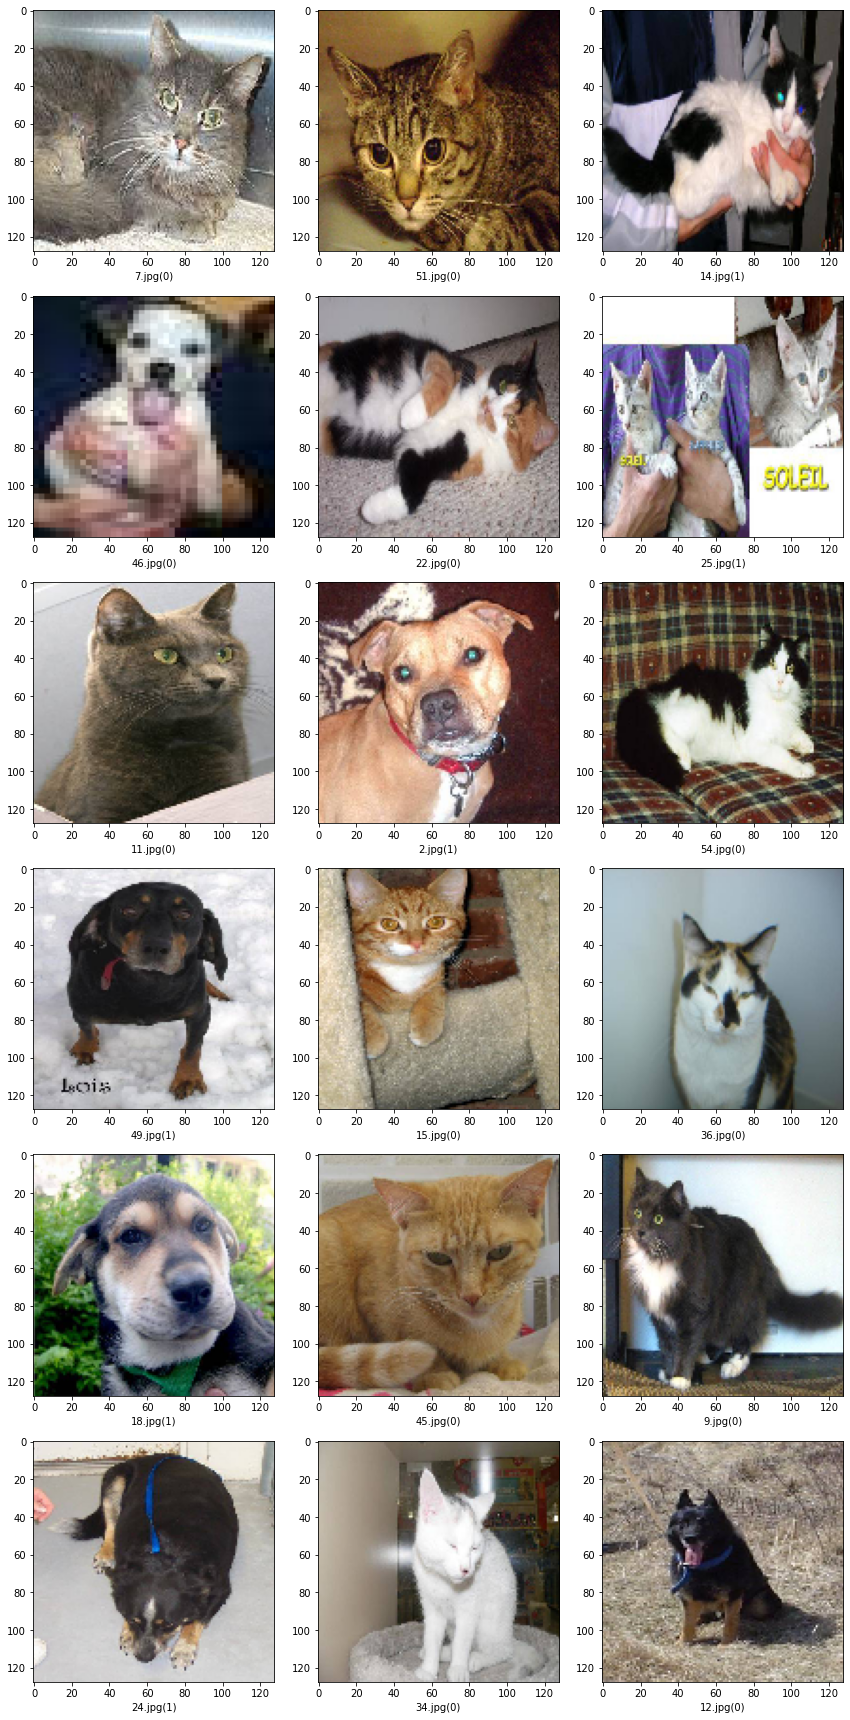

In [42]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/drive/MyDrive/test_500/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [43]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)